## Chapter 14 : Computer Vision
- How to compute the reception field : from top to bottom. $r_i = (r_{i+1}-1) * s_i + k_i$.
- Image Augmantation
  - torchvision.transforms.RandomHorizontalFlip, RandomResizedCrop, ColorJitter... and use Compose to combine them. Use ToTensor to convert to tensor.
- Fine tunning
  - <img alt="Fine tunning" src="https://d2l.ai/_images/finetune.svg" style="background-color: white; display: inline-block;"> Fine tunning
  - Change the output layer, random init it, then use a small lr to train it (Output layer can have bigger lr than other layers).
  - torchvision.datasets.ImageFolder get image dataset
- Anchor Box :
  - from a pixel get (s1, r_i(up to m)) and (s_i(up to n), r1), s is scale, r is width / height, so we have wh(n+m-1) anchor boxes, w and h is the img size. Anchor width and height is $hs\sqrt r$ and $hs / \sqrt r$. Here we assume that h == w, if it is not the case then $hs\sqrt r$ and $ws/\sqrt r$.
  - IoU, Inter over Union.
  - How to assign ground truth to anchor box? Given anchors $A_1, \ldots, A_{n_c}$, and ground truth $B_1, \ldots, B_{n_t}$. We have a matrix $X \in \mathbb R^{n_c \times n_t}$, $X_{i, j}$ is IoU of $A_i$ and $B_j$. Find max number in $\max X = X_{i_1, j_1}$, assign $B_{j_1}$ to $A_{i_1}$, abandon $i_1$ row and $j_1$ col. Find again and again until we finish assign B. For left A, find in it's row max B, if the IoU is bigger than some threshold, assign B to A.
  - We then compute the offset with $\left( \frac{\frac{x_{b}-x_{a}} {w_{a}}-\mu_{x}} {\sigma_{x}}, \frac{\frac{y_{b}-y_{a}} {h_{a}}-\mu_{y}} {\sigma_{y}}, \frac{\operatorname{l o g} \frac{w_{b}} {w_{a}}-\mu_{w}} {\sigma_{w}}, \frac{\operatorname{l o g} \frac{h_{b}} {h_{a}}-\mu_{h}} {\sigma_{h}} \right) $, mean set to 0, and $\sigma_{y} = \sigma_{x} = 0.1, \sigma_{w} = \sigma_{h} = 0.2$. Normalization will make the training more stable. And we do not compute offset for IoU < threshold anchors, so we use a mask to filter it. For other anchors, we have predict_offset that will compare with offsets for tranining.
  - non-maximum suppression，NMS: we sort all the anchors with it's class predict accuracy. In a loop, choose max one, delete all the other anchors with IoU (with the choosen anchor) larger than a threshold. We can also first erase all the anchors based on some threshold to decrease computational cost.
- Single Shot Multibox Detection
  - <img alt="SSD" src="https://d2l.ai/_images/ssd.svg" style="background-color: white; display: inline-block;"> SSD
  - Use Conv2d rather than FC to get prediction. Flatten different feature map on the dim != 0 (batch_size), then cat them so we have connect different feature map. nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), kernel_size=3, padding=1) for class data and nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1) for offset.
- Region-based CNNs (R-CNNs)
  - RCNN:
    1. Use a select algorithm to select region proposals from the input image and resize it (to match the cnn below)
    2. pass all the regions to a pre trained CNN to get the feature (it is slow!)
    3. Use these feature train n_class + 1 SVM
    4. combine the feature and the box as a sample, train a linear regression model
    5. <img alt="RCNN" src="https://d2l.ai/_images/r-cnn.svg" style="background-color: white; display: inline-block;"> RCNN
  - Fast RCNN
    1. still use select algorithm, but just go through CNN once, and project the proposal to the feature map.
    2. use ROI Pooling to convert these feature maps to the same output size (7 * 7), roi pool is max pool. ROI pool will first divide the region into 7 * 7 regions and then quantize, because the region of interest in the feature map has corrdinate in float type, but what we need is int type. So quantize them to int, and do the max pool, we get 7 * 7 output. There are 2 quantization, first the feature map corrdinates and the division.
    3. then use FC to get two branch : one for N(n_class + 1), and 4N for the box.
    4. <img alt="RCNN" src="https://d2l.ai/_images/fast-rcnn.svg" style="background-color: white; display: inline-block;"> Fast RCNN
  - Faster RCNN
    1. use a RPN net (region proposal network) : use a pad = 1, k = 3 conv to extract new feature from the origin feature from the base net. Then get anchors from this new feature map, get class predict (! this is not the full class predict, it is only binary class predict -- background or not) and box predict, go through NMS and fuse with origin feature.
    2. <img alt="Faster RCNN" src="https://d2l.ai/_images/faster-rcnn.svg" style="background-color: white; display: inline-block;"> Faster RCNN
  - Masked RCNN
    1. If we have detailed pixel information of the target, we can replace ROI pool with region of interest alignment, use bipolar interpolation to preserve spatial information. This can then use a FC to get class and box, or use a conv layer to get pixel detailed information of the origiin img (segment).
    2. ROI Align: compare with ROI pool, we do not quantize, instead we use samples. We divede the region in to the output shape we want (in float type), and for each cell do another division. For example, if we set hyperparameter sample size to $n \times n$, then divede the cell to $n \times n$. For each cell in the cell, calculate the value based on bipolar interpolation: $F(x,y) = \sum_{a,b} F(\lfloor x \rfloor + a, \lfloor y \rfloor + b) \cdot \max(0, 1-|x-(\lfloor x \rfloor + a)|) \cdot \max(0, 1-|y-(\lfloor y \rfloor + b)|)$, for $a, b \in \{0, 1\}$. Finally, get the average on $n \times n$ cell in cell, get the cell value.
    3. If you interested in more, we have a precise ROI pool: same as ROI align we do not quantize, but we do not do the divide into samples too. Instead we do a integral on the cell.
    4. <img alt="Masked RCNN" src="https://d2l.ai/_images/mask-rcnn.svg" style="background-color: white; display: inline-block;"> Masked RCNN
- semantic segmentation
  - image segmentation do not care about the semantic, semantic segmentation cares (it will distinguish dog and cat), instance segmentation also called simultaneous detection and segmentation not only has semantic information but also distinguish different object (two dogs and three cats are different).
  - semantic data augmentation will not scale, only crop
- Transposed Convolution
  - Conv animation : [https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md](conv_animation)
  - Normal convolution will downsample the height and width, transposed one will increase it, it is the gradient of the std convolution. (but tconv(conv(x)) != x, there is imformation loss)
  - Y[i: i + h, j: j + w] += X[i, j] * K and the torch function is nn.ConvTranspose2d
  - Just see the code and it's comment below.
  - <img alt="Transposed Convolution" src="https://d2l.ai/_images/trans_conv.svg" style="background-color: white; display: inline-block;">
- Fully Convolutional Networks
  - In order to give every pixel it's class predict, we can use transposed convolution to transform the feature back into the original shape.
  - We use a pretrained ResNet base net, get rid of last two layers (an adaptive avg pool and a linear), connect it to 1 * 1 conv kernel with channel == num_classes, and a transposed convolution layer.
  - We often use bi-linear interpolation to initialize the transposed convolution layer. See in test.ipynb.
- Neural Style Transfer
  - We need two inputs, one content image, one style image. We use a pretrained CNN base model as the feature extractor, some layers will be use as content image feature, some as style image feature. The model param is frozen!!! The only parameter will change is the synthesized image. We have three loss, the total variation loss is to reduce the noise.
  - In the example in book, we use deeper layer as the content layer (do not focus on detail), and different depth layer for style layer (focus both detail and global).
  - Loss: for content loss we use torch.square(Y_hat - Y.detach()).mean(), stop the gradient flow throgh the target content image Y, it is a stated value, not a variable (and Y_hat is content_layer(content_x)). For style loss, we use the gram matrix to get correlation of the style features of different channels, for a [n, c, h, w] feature, reshape it to [c, nhw] matrix X and calculate G = XX^T, loss = torch.square(gram(Y_hat) - gram_Y.detach()).mean(). For total variation loss, $\sum_{i, j}|x_{i,j} - x_{i+1,j}|+|x_{i,j} - x_{i,j+1}|$, this will reduce the noise. Add all the content loss and style loss in all the correspoding layers with the weight and the total loss with it's weight we get the total loss. Note in book example, X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y) the first X (target data) is a copy of second X (origin content img), it is two different data.
  - <img alt="neural-style" src="https://d2l.ai/_images/neural-style.svg" style="background-color: white; display: inline-block;"> Neural Style
<!-- <img alt="ResNeXt Block" src="https://d2l.ai/_images/rnn.svg" style="background-color: white; display: inline-block;"> -->
<!-- <img alt="ResNeXt Block" src="https://d2l.ai/_images/rnn-bptt.svg" style="background-color: white; display: inline-block;"> -->

In [1]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from torchinfo import summary
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
import numpy as np
import time
import os
import torchvision
from PIL import Image
backend_inline.set_matplotlib_formats('svg')

In [2]:
figsize = (3.5, 2.5)
plt.rcParams['figure.figsize'] = figsize

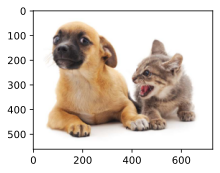

In [75]:
img = Image.open('../../Data/catdog.jpg')
plt.imshow(img)

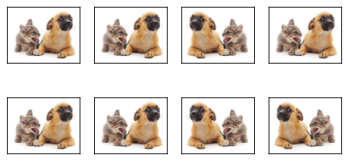

In [76]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

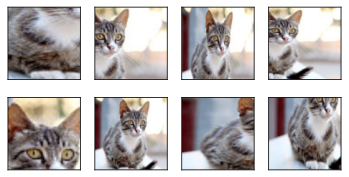

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

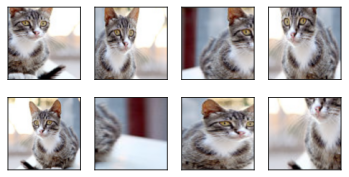

In [7]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), shape_aug])
apply(img, augs)

In [4]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale=scale)

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_utils`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = np.array(img)
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [11]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../../Data",
                                          download=False)

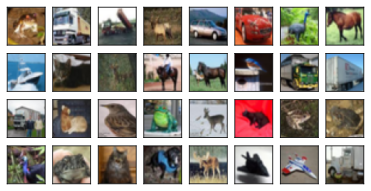

In [13]:
show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [15]:
np.array(all_images[0][0]).shape

(32, 32, 3)

In [16]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../../Data", train=is_train,
                                           transform=augs, download=False)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=4)
    return dataloader

In [17]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [21]:
def train_cifar_batch(net, X, y, trainer, loss):
    X = X.to('cuda')
    y = y.to('cuda')
    net.train()
    trainer.zero_grad()
    l = loss(net(X), y).sum()
    l.backward()
    trainer.step()
    return l

def get_test_loss(net, test_iter, loss):
    net.eval()
    l = 0
    cnt = 0
    for X, y in test_iter:
        X = X.to('cuda')
        y = y.to('cuda')
        with torch.no_grad():
            l += loss(net(X), y).sum()
            cnt += 1
    return l / cnt
    
def train_cifar(net, train_iter, test_iter, trainer, loss, num_epochs):
    net = net.to('cuda')
    for epoch in range(num_epochs):
        for i, (feature, label) in enumerate(train_iter):
            l = train_cifar_batch(net, feature, label, trainer, loss)
            if i % 10 == 0:
                print(f"training loss : {l})
        l_test = get_test_loss(net, test_iter, loss)
        print(f"training loss : {l}, testing loss : {l_test}")

In [29]:
def train_with_data_aug(train_augs, test_augs, net, batch_size, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    print(next(iter(train_iter))[0].shape)
    train_cifar(net, train_iter, test_iter, trainer, loss, 10)

def init_cnn(module):
    """Initialize weights for CNNs.

    Defined in :numref:`sec_lenet`"""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [30]:
batch_size, net = 16, resnet18(10, 3)
net.apply(init_cnn)
train_with_data_aug(train_augs, test_augs, net, batch_size)

torch.Size([16, 3, 32, 32])
training loss : 23.0782470703125, testing loss : 16.480541229248047


KeyboardInterrupt: 

In [25]:
summary(net, input_size = (8, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [8, 10]                   --
├─Conv2d: 1-1                            [8, 64, 32, 32]           1,792
├─BatchNorm2d: 1-2                       [8, 64, 32, 32]           128
├─ReLU: 1-3                              [8, 64, 32, 32]           --
├─Sequential: 1-4                        [8, 64, 32, 32]           --
│    └─Residual: 2-1                     [8, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [8, 64, 32, 32]           36,928
│    │    └─BatchNorm2d: 3-2             [8, 64, 32, 32]           128
│    │    └─Conv2d: 3-3                  [8, 64, 32, 32]           36,928
│    │    └─BatchNorm2d: 3-4             [8, 64, 32, 32]           128
│    └─Residual: 2-2                     [8, 64, 32, 32]           --
│    │    └─Conv2d: 3-5                  [8, 64, 32, 32]           36,928
│    │    └─BatchNorm2d: 3-6             [8, 64, 32, 32]           

In [18]:
class Residual(nn.Module):
    """The Residual block of ResNet models.

    Defined in :numref:`sec_resnet`"""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

def resnet18(num_classes, in_channels=1):
    """A slightly modified ResNet-18 model.

    Defined in :numref:`sec_multi_gpu_concise`"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(out_channels, use_1x1conv=True,
                                        strides=2))
            else:
                blk.append(Residual(out_channels))
        return nn.Sequential(*blk)

    # This model uses a smaller convolution kernel, stride, and padding and
    # removes the max-pooling layer
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

In [31]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);# 如果param_group=True，输出层中的模型参数将使用十倍的学习率

C:\ProgramData\miniconda3\envs\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\miniconda3\envs\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\pc/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [ ]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

In [32]:
'''
Object Detection
'''

'\nObject Detection\n'

In [2]:
'''
Bounding Box
'''

def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save
def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes


In [3]:
# torch.set_printoptions(2)  # 精简输出精度
#@save
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框"""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # 在y轴上缩放步长
    steps_w = 1.0 / in_width  # 在x轴上缩放步长

    # 生成锚框的所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # 生成“boxes_per_pixel”个高和宽，
    # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax), w = size * sqrt(ratio), h = size / sqrt(ratio)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]), # this cat is to create n + m - 1
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # 处理矩形输入
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # 除以2来获得半高和半宽
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # 每个中心点都将有“boxes_per_pixel”个锚框，
    # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format.

    Defined in :numref:`sec_bbox`"""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)
    
#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

torch.Size([1, 2042040, 4])
torch.Size([4])
torch.Size([561, 728, 5, 4])


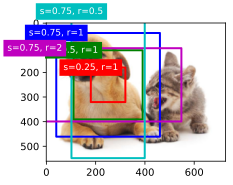

In [126]:
h, w = np.array(img).shape[:2]
bbox_scale = torch.tensor((w, h, w, h))
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
boxes = Y.reshape(h, w, 5, 4)
print(Y.shape)
print(bbox_scale.shape)
print(boxes.shape)
fig = plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

In [4]:
'''
IoU
'''
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1：(boxes1的数量,4),
    # boxes2：(boxes2的数量,4),
    # areas1：(boxes1的数量,),
    # areas2：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # inter_upperlefts,inter_lowerrights,inters的形状:
    # (boxes1的数量,boxes2的数量,2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # inter_areasandunion_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [5]:
'''
Assign Ground Truth to Anchor Boxes:
1. first for every anchor boxes with iou > threshold assign a ground truth (the max one in that row)
2. and in a for loop, adjust the map. Get max from the matrix and assign it to according anchor. Mask
all the data in that col and row with -1, get max... and we assign all the ground truth.
'''
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # 先根据阈值，决定是否分配真实边界框，然后再从大到小分配
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold # [anc_i, box_j] is the anchors with large iou
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

In [6]:
'''
Compute Offsets
'''
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [30]:
#@save
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device) # anchor[i] 分给了 anchors_bbox_map[i]
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat( 
            1, 4)   # we do not compute offset for background types, so use this mask it
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask # Here we mask it!
        # print(label.shape, anchors_bbox_map.shape, bbox_mask.shape)
        # print(anchors_bbox_map)
        # print(bbox_mask)
        # print(offset)
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

torch.Size([2, 5]) torch.Size([5, 4])


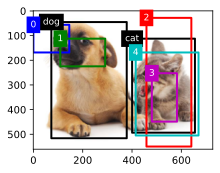

In [101]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])
print(ground_truth.shape, anchors.shape)
fig = plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [89]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

torch.Size([2, 5]) torch.Size([5]) torch.Size([5, 4])
tensor([-1,  0,  1, -1,  1])
tensor([[0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.]])
tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00],
        [ 1.40e+00,  1.00e+01,  2.59e+00,  7.18e+00],
        [-1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00],
        [-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00],
        [-5.71e-01, -1.00e+00,  4.17e-06,  6.26e-01]])


In [90]:
j = box_iou(anchors, ground_truth[:, 1:])
max_ious, indices = torch.max(j, dim = 1)
print(max_ious, indices)
anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
print(anc_i)

tensor([0.05, 0.14, 0.57, 0.21, 0.75]) tensor([0, 0, 1, 1, 1])
tensor([2, 4])


In [8]:
'''
Reverse Offsets
'''
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

'''
non-maximum suppression，NMS
'''
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

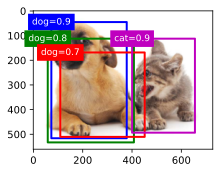

In [105]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率
fig = plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

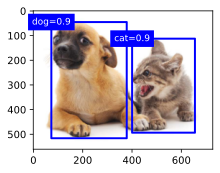

In [106]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output
fig = plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

In [9]:
def display_anchors(fmap_w, fmap_h, s):
    # 前两个维度上的值不影响输出
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    show_bboxes(plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

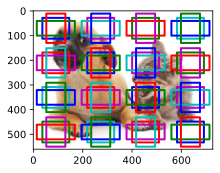

In [108]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

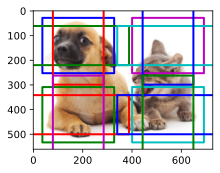

In [127]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

In [15]:
in_height, in_width = 10, 10
offset_h, offset_w = 0.5, 0.5
steps_h = 1.0 / in_height  # 在y轴上缩放步长
steps_w = 1.0 / in_width  # 在x轴上缩放步长

# 生成锚框的所有中心点
center_h = (torch.arange(in_height) + offset_h) * steps_h
center_w = (torch.arange(in_width) + offset_w) * steps_w
shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
sizes = [0.15, 0.3, 0.45]
size_tensor = torch.tensor([0.15, 0.3, 0.45])
ratio_tensor = torch.tensor([2, 1, 0.5])
w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # 处理矩形输入
h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # 除以2来获得半高和半宽
anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                    in_height * in_width, 1) / 2

boxes_per_pixel = 5
# 每个中心点都将有“boxes_per_pixel”个锚框，
# 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
            dim=1).repeat_interleave(boxes_per_pixel, dim=0)
Y = out_grid + anchor_manipulations

boxes = Y.reshape(in_height, in_width, 5, 4)
ans = boxes * torch.tensor((in_height, in_width, in_height, in_width))
print(center_h)
# print(size_tensor * torch.sqrt(ratio_tensor[0]))
# print(torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
#                    sizes[0] * torch.sqrt(ratio_tensor[1:]))))
# print(center_w)
# print(shift_y)
print(w)
print(h)
print(torch.stack((-w, -h, w, h)).shape)
print(anchor_manipulations, anchor_manipulations.shape)
print(output.shape)
print(boxes.shape)
print(ans[0][0])

tensor([0.0500, 0.1500, 0.2500, 0.3500, 0.4500, 0.5500, 0.6500, 0.7500, 0.8500,
        0.9500])
tensor([0.2121, 0.4243, 0.6364, 0.1500, 0.1061])
tensor([0.1061, 0.2121, 0.3182, 0.1500, 0.2121])
torch.Size([4, 5])
tensor([[-0.1061, -0.0530,  0.1061,  0.0530],
        [-0.2121, -0.1061,  0.2121,  0.1061],
        [-0.3182, -0.1591,  0.3182,  0.1591],
        ...,
        [-0.3182, -0.1591,  0.3182,  0.1591],
        [-0.0750, -0.0750,  0.0750,  0.0750],
        [-0.0530, -0.1061,  0.0530,  0.1061]]) torch.Size([500, 4])
torch.Size([500, 4])
torch.Size([10, 10, 5, 4])
tensor([[-0.5607, -0.0303,  1.5607,  1.0303],
        [-1.6213, -0.5607,  2.6213,  1.5607],
        [-2.6820, -1.0910,  3.6820,  2.0910],
        [-0.2500, -0.2500,  1.2500,  1.2500],
        [-0.0303, -0.5607,  1.0303,  1.5607]])


In [23]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = "../../Data/banana-detection"
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

#@save
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [17]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)                 # (For below) The batch and channel of Y is not important (or we treat them the same)
    anchors = multibox_prior(Y, sizes=size, ratios=ratio) # anchor size is (1, Y_h * Y_w, size_len + ratio_size - 1)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [25]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [34]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self,'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
            # print("The shape in the TinnySSd:", X.shape, anchors[i].shape, cls_preds[i].shape, bbox_preds[i].shape)
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [35]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)
# 5444 = 4096 + 1024 + 256 + 64 + 4, 21776 = 5444 * 4

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [26]:
import pandas as pd
batch_size = 32
train_iter, _ = load_data_bananas(batch_size)
device, net = 'cuda', TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')


def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

read 1000 training examples
read 100 validation examples


In [36]:
num_epochs = 20

net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    net.train()
    for features, target in train_iter:
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric = (cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')

class err 5.96e-01, bbox mae 7.33e-03
class err 6.03e-01, bbox mae 6.61e-03
class err 6.01e-01, bbox mae 6.58e-03
class err 6.00e-01, bbox mae 5.73e-03
class err 5.86e-01, bbox mae 6.53e-03
class err 5.83e-01, bbox mae 6.77e-03
class err 5.77e-01, bbox mae 6.07e-03
class err 5.82e-01, bbox mae 6.05e-03
class err 5.90e-01, bbox mae 7.36e-03
class err 5.88e-01, bbox mae 4.60e-03
class err 5.79e-01, bbox mae 5.21e-03
class err 5.92e-01, bbox mae 5.54e-03
class err 6.03e-01, bbox mae 6.24e-03
class err 6.01e-01, bbox mae 7.73e-03
class err 5.79e-01, bbox mae 6.74e-03
class err 5.83e-01, bbox mae 5.09e-03
class err 5.86e-01, bbox mae 7.48e-03
class err 5.97e-01, bbox mae 5.26e-03
class err 5.80e-01, bbox mae 6.73e-03
class err 5.98e-01, bbox mae 6.13e-03


In [46]:
X = torchvision.io.read_image('../../Data/banana-detection/bananas_val/images/10.png').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [47]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

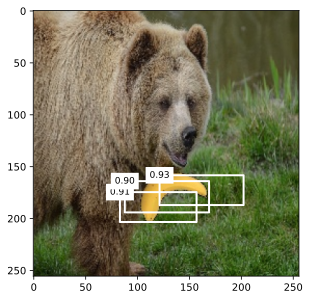

In [48]:
def display(img, output, threshold):
    fig = plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)

In [2]:
X = torch.arange(16.).reshape(1, 1, 4, 4)
rois = torch.Tensor([[0, 0, 0, 20, 20], [0, 0, 10, 30, 30]])
torchvision.ops.roi_pool(X, rois, output_size=(2, 2), spatial_scale=0.1)

tensor([[[[ 5.,  6.],
          [ 9., 10.]]],


        [[[ 9., 11.],
          [13., 15.]]]])

In [ ]:
'''
transposed convolution:
1. Takes each input value
2. Multiplies it by the entire kernel
3. Places the result at the corresponding output location
4. Overlapping regions are summed
'''
def naive_transposed_conv2d(input_tensor, kernel, stride=1, padding=0):
    """
    Naive implementation of 2D transposed convolution for educational purposes.
    
    Args:
        input_tensor: Input tensor (batch_size, channels, height, width)
        kernel: Convolution kernel (out_channels, in_channels, kernel_h, kernel_w)
        stride: Stride value
        padding: Padding value
    
    Returns:
        Output tensor after transposed convolution
    """
    batch_size, in_channels, in_h, in_w = input_tensor.shape
    out_channels, _, kernel_h, kernel_w = kernel.shape
    
    # Calculate output dimensions
    out_h = (in_h - 1) * stride - 2 * padding + kernel_h
    out_w = (in_w - 1) * stride - 2 * padding + kernel_w
    
    # Initialize output tensor
    output = torch.zeros(batch_size, out_channels, out_h, out_w)
    
    # Perform transposed convolution
    for b in range(batch_size):
        for i in range(in_h):
            for j in range(in_w):
                for c_in in range(in_channels):
                    for c_out in range(out_channels):
                        # Calculate output position
                        start_h = i * stride - padding
                        start_w = j * stride - padding
                        end_h = start_h + kernel_h
                        end_w = start_w + kernel_w
                        
                        # Add contribution if within bounds
                        if (start_h >= 0 and end_h <= out_h and 
                            start_w >= 0 and end_w <= out_w):
                            output[b, c_out, start_h:end_h, start_w:end_w] += \
                                input_tensor[b, c_in, i, j] * kernel[c_out, c_in]
    
    return output

In [8]:
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
tconv.weight.data = K
print(tconv(X))
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding = 1, bias=False)
tconv.weight.data = K
print(tconv(X))
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride = 2, bias=False)
tconv.weight.data = K
print(tconv(X))

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<ConvolutionBackward0>)
tensor([[[[4.]]]], grad_fn=<ConvolutionBackward0>)
tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<ConvolutionBackward0>)
